# Chatbot (Generasi Puisi) menggunakan Recurrent Neural Network (RNN) & Long Short-Term Memory (LSTM)
## Anggota Kelompok 1
1. Zakiyah Hasanah (2305274)
2. Putra Hadiyanto Nugroho (2308163)
3. Hafsah Hamidah (2311474)
4. Natasha Adinda Cantika (2312120)


## Pendahuluan

Proyek ini bertujuan untuk membuat model Text Generation yang mampu menghasilkan puisi baru berdasarkan input berupa judul puisi yang diberikan. Arsitektur inti menggunakan Sequence-to-Sequence (Seq2Seq), yang terdiri dari Encoder (memproses Judul) dan Decoder (menghasilkan Puisi).

Model dibandingkan dengan mengevaluasi efektivitas dua arsitektur Recurrent Neural Network (RNN) utama dalam tugas Text Generation yang kompleks:
* SimpleRNN - sebagai baseline.
* Long Short-Term Memory (LSTM) - untuk memproses konteks dan dependensi jangka panjang.

Kinerja dan kualitas hasil puisi akan dievaluasi secara kuantitatif menggunakan metrik khusus Text Generation, yaitu ROUGE Score.

### Sumber Dataset

Kami menggunakan dataset Puisi Indonesia yang diupload oleh Ilham Firdausi Putra di Kaggle:
https://www.kaggle.com/datasets/ilhamfp31/puisi-indonesia/

---



## 1. Persiapan, Data, dan Pra-pemrosesan Teks

Bagian ini berfokus pada penyiapan lingkungan, definisi *hyperparameter*, dan struktur dasar data untuk model Seq2Seq.


Pertama kami impor library yang diperlukan.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Embedding, Attention, Concatenate
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt


### 1.1. Definisi Token Khusus & Parameter
Bagian ini mendefinisikan *hyperparameters* utama yang mengontrol kompleksitas dan kecepatan pelatihan model, seperti:
* `START_TOKEN`, `END_TOKEN`, `UNK_TOKEN`: Token wajib untuk penanda awal/akhir urutan dan kata-kata tidak dikenal.
* `NEWLINE_TOKEN (<br>)`: **Token Kunci** yang digunakan untuk menggantikan karakter *newline* (`\n`) dalam puisi, memungkinkan model belajar struktur baris.
* `RNN_UNITS=256`, `EMBEDDING_DIM=128`,`BATCH_SIZE=64`: *Hyperparameter* yang menentukan kompleksitas model dan penggunaan memori selama pelatihan.


In [2]:
START_TOKEN = '<start>'
END_TOKEN = '<end>'
UNK_TOKEN = '<unk>'
NEWLINE_TOKEN = '<br>'

EMBEDDING_DIM = 128   
RNN_UNITS = 256       
BATCH_SIZE = 64       
EPOCHS = 100          


### 1.2. Pengambilan Data
Dataset puisi diunduh, dan hanya kolom 'puisi' dan 'title' yang dipertahankan. Baris yang memiliki nilai null dihapus.

In [8]:
DATASET_URL = "https://raw.githubusercontent.com/beginnener/DeepLearning_RNN/refs/heads/main/dataset/dataset-chatbot/puisi.csv"
df = pd.read_csv(DATASET_URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7223 entries, 0 to 7222
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   puisi              7221 non-null   object
 1   title              6903 non-null   object
 2   author             6697 non-null   object
 3   puisi_with_header  7223 non-null   object
dtypes: object(4)
memory usage: 225.8+ KB


In [9]:
# Hanya ambil kolom puisi dan title
df = df[['puisi', 'title']].dropna().reset_index(drop=True)
print(f"Data berhasil dimuat. Jumlah baris yang digunakan: {len(df)}")
df.head()

Data berhasil dimuat. Jumlah baris yang digunakan: 6901


,puisi,title
0,Awal mata memandangredup lenyap dalam terang t...,DIA YANG BUKAN MILIKKU
1,Ketika penguasa telah bertahta \n Rakyat jelat...,SANG PENGUASA
2,Kau raja bukan raja \n Malaikat juga bukan \n ...,NIKOTIN
3,Sahabat engkau adalah orang yang paling mernge...,PERSAHABATAN
4,Dan ini diawali dengan sebutan cinta. \n Dan i...,DISETIAPNYA TERDAPAT TAMU BERBEDA PUJIAN



### 1.3. Pembersihan Teks
Fungsi `clean_text` diterapkan pada seluruh data. Fungsi ini melakukan normalisasi dasar (huruf kecil, penghapusan angka, penghapusan tanda baca non-token) dan yang paling penting, ia secara eksplisit mengganti semua karakter *newline* Python (`\n`) dalam kolom puisi dengan token khusus `<br>`. Langkah ini memastikan bahwa model belajar kapan harus menyisipkan jeda baris sebagai bagian dari urutan yang diprediksi.

In [105]:
def clean_text(text, is_poem=False):
    """Menghilangkan karakter khusus dan mengganti newline dengan <br>."""
    text = str(text).lower()

    # GANTI NEWLINE (\n) dengan token <br> HANYA pada puisi
    if is_poem:
        text = re.sub(r'\n', ' ' + NEWLINE_TOKEN + ' ', text)

    text = re.sub(r'[^a-z0-9\s<>]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# coba debug sebelum apply clean_text
print(df['puisi'][1])

# Membersihkan kolom 'puisi' (dengan is_poem=True) dan 'title'
df['puisi'] = df['puisi'].apply(lambda x: clean_text(x, is_poem=True))
df['title'] = df['title'].apply(clean_text, is_poem=False)

# coba debug setelah apply clean_text
print(df['puisi'][1])

Ketika penguasa telah bertahta 
 Rakyat jelata pasti yang menderita 
 Ketika para penguasa telah ujuk gigi 
 Rakyat miskin hanya bisa gigit jari 
 Mereka tak akan pernah peduli 
 Yang menentang sudah pasti dibui 
 Yang berkuasa hukum diperjual beli 
 Yang salah dijadikan benar 
 Yang benar akan diadili 
 Itulah indonesia.. 
 Hukum bisa diatur sendiri 
  
 
ketika penguasa telah bertahta <br> rakyat jelata pasti yang menderita <br> ketika para penguasa telah ujuk gigi <br> rakyat miskin hanya bisa gigit jari <br> mereka tak akan pernah peduli <br> yang menentang sudah pasti dibui <br> yang berkuasa hukum diperjual beli <br> yang salah dijadikan benar <br> yang benar akan diadili <br> itulah indonesia <br> hukum bisa diatur sendiri <br> <br>



### 1.4. Mempersiapkan Data Seq2Seq (Title $\rightarrow$ Poem)

Data dipersiapkan untuk arsitektur Encoder-Decoder. Kolom Judul (`df['title']`) ditetapkan sebagai input Encoder (X). Kolom Puisi (yang sudah mengandung token `<br>`) ditetapkan sebagai target Decoder (Y). Untuk proses *teacher forcing* selama pelatihan, kami membuat dua versi target: `Y_inp` (diawali `<start>`) dan `Y_tar` (diakhiri `<end>`). Data kemudian dibagi menjadi set pelatihan dan pengujian (80/20).

* **Tujuan:** Mendefinisikan pasangan Input (Encoder) dan Target (Decoder).
* **Pasangan:**
    * **Encoder Input (X):** `df['title']` (Judul).
    * **Decoder Input (Y\_inp):** `<start>` + `df['puisi']` (Puisi Target, digunakan untuk *teacher forcing*).
    * **Decoder Target (Y\_tar):** `df['puisi']` + `<end>` (Puisi Target sebenarnya, digunakan untuk menghitung *loss*).


In [106]:
X = df['title']
Y_inp = START_TOKEN + ' ' + df['puisi']
Y_tar = df['puisi'] + ' ' + END_TOKEN

X_train, X_test, y_train_inp, y_test_inp, y_train_tar, y_test_tar = train_test_split(
    X, Y_inp, Y_tar, test_size=0.2, random_state=42
)
print("\nPra-pemrosesan data selesai.")
df.head()


Pra-pemrosesan data selesai.


,puisi,title
0,awal mata memandangredup lenyap dalam terang t...,dia yang bukan milikku
1,ketika penguasa telah bertahta <br> rakyat jel...,sang penguasa
2,kau raja bukan raja <br> malaikat juga bukan <...,nikotin
3,sahabat engkau adalah orang yang paling mernge...,persahabatan
4,dan ini diawali dengan sebutan cinta <br> dan ...,disetiapnya terdapat tamu berbeda pujian


## 2. Tokenisasi dan Padding

Bagian ini mengubah teks menjadi urutan integer (angka) dan memastikan panjangnya seragam.



### 2.1. Tokenisasi
Langkah ini mengubah kata-kata dalam teks menjadi representasi numerik. Dua objek `Tokenizer` Keras digunakan; satu untuk Judul (Encoder Input) dan satu untuk Puisi (Decoder Target). 

Pada *tokenizer* target, kami menggunakan *filter* kosong dan mencantumkan token khusus (`<start>`, `<end>`, `<br>`) untuk memastikan bahwa mereka diperlakukan sebagai kata tunggal dan tidak dihapus selama proses tokenisasi. Ukuran *vocabulary* (`vocab_size`) dihitung sebagai total kata unik ditambah satu untuk *padding*.


In [107]:
# Tokenisasi Input (Judul)
# Gunakan filters='' untuk memastikan token khusus tidak dihapus
tokenizer_input = Tokenizer(oov_token=UNK_TOKEN, filters='')
tokenizer_input.fit_on_texts(X_train)
X_train_seq = tokenizer_input.texts_to_sequences(X_train)
X_test_seq = tokenizer_input.texts_to_sequences(X_test)
vocab_size_input = len(tokenizer_input.word_index) + 1

# Tokenisasi Target (Puisi)
# Pastikan token khusus <start>, <end>, dan <br> tidak dihapus 
tokenizer_target = Tokenizer(oov_token=UNK_TOKEN, filters=[])
tokenizer_target.fit_on_texts(y_train_inp.tolist() + y_train_tar.tolist())
y_train_inp_seq = tokenizer_target.texts_to_sequences(y_train_inp)
y_test_inp_seq = tokenizer_target.texts_to_sequences(y_test_inp)
y_train_tar_seq = tokenizer_target.texts_to_sequences(y_train_tar)
y_test_tar_seq = tokenizer_target.texts_to_sequences(y_test_tar)
vocab_size_target = len(tokenizer_target.word_index) + 1

print("Tokenisasi Selesai.")
print(f"Jumlah Kata Unik (Input): {vocab_size_input}")
print(f"Jumlah Kata Unik (Target): {vocab_size_target}")

Tokenisasi Selesai.
Jumlah Kata Unik (Input): 3285
Jumlah Kata Unik (Target): 39147


### 2.2. Padding
Padding digunakan untuk menyamakan panjang semua urutan data. Urutan Judul dan Puisi diubah menjadi *array* dengan panjang seragam (`MAX_LEN_INPUT` dan `MAX_LEN_TARGET`) menggunakan *padding* (`pad_sequences`). *Padding* diisi dengan nol di akhir urutan (`padding='post'`). Urutan puisi (`MAX_LEN_TARGET`) adalah yang terpanjang dan paling berpengaruh terhadap waktu pelatihan. *Padding* ini memastikan tensor data memiliki dimensi yang konsisten, yang diperlukan untuk pelatihan *batch* pada model Keras/TensorFlow.

In [108]:
# Karena data dipotong, max length juga akan lebih kecil (membantu kecepatan)
MAX_LEN_INPUT = max(len(seq) for seq in X_train_seq)
MAX_LEN_TARGET = max(len(seq) for seq in y_train_inp_seq)

# Batasi MAX_LEN_TARGET agar tidak terlalu panjang (opsional, tapi disarankan)
MAX_LEN_TARGET = min(MAX_LEN_TARGET, 100)

# Gunakan padding pada semua sequence untuk menyamakan panjang
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN_INPUT, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN_INPUT, padding='post')

y_train_inp_pad = pad_sequences(y_train_inp_seq, maxlen=MAX_LEN_TARGET, padding='post')
y_test_inp_pad = pad_sequences(y_test_inp_seq, maxlen=MAX_LEN_TARGET, padding='post')

y_train_tar_pad = pad_sequences(y_train_tar_seq, maxlen=MAX_LEN_TARGET, padding='post', truncating='post')
y_test_tar_pad = pad_sequences(y_test_tar_seq, maxlen=MAX_LEN_TARGET, padding='post', truncating='post')

print("Padding Selesai.")
print(f"Panjang Max Judul (Input): {MAX_LEN_INPUT}")
print(f"Panjang Max Puisi (Target): {MAX_LEN_TARGET}")

Padding Selesai.
Panjang Max Judul (Input): 9
Panjang Max Puisi (Target): 100



## 3. Model Seq2Seq dengan SimpleRNN



### 3.1. Pembuatan Model SimpleRNN Seq2Seq

Model ini adalah arsitektur Seq2Seq paling dasar. **Encoder** SimpleRNN memproses urutan Judul dan menghasilkan satu vektor *hidden state* ($h$) yang berfungsi sebagai ringkasan konten Judul. **Decoder** SimpleRNN menerima *hidden state* ini sebagai *initial state* dan memprediksi urutan Puisi, token demi token. 

Lapisan *Dense* dengan `softmax` diterapkan di akhir untuk menghasilkan probabilitas setiap kata dalam *vocabulary* target. Model dikompilasi dengan *loss* `sparse_categorical_crossentropy` dan diukur dengan `accuracy` per-token.

In [109]:
# Encoder
encoder_inputs_rnn = Input(shape=(MAX_LEN_INPUT,), name='enc_in_rnn')
enc_emb_rnn = Embedding(vocab_size_input, EMBEDDING_DIM, mask_zero=True)(encoder_inputs_rnn)
encoder_rnn = SimpleRNN(RNN_UNITS, return_state=True)
_, state_h_rnn = encoder_rnn(enc_emb_rnn)
encoder_states_rnn = [state_h_rnn]

# Decoder
decoder_inputs_rnn = Input(shape=(MAX_LEN_TARGET,), name='dec_in_rnn')
dec_emb_rnn = Embedding(vocab_size_target, EMBEDDING_DIM, mask_zero=True)(decoder_inputs_rnn)
decoder_rnn = SimpleRNN(RNN_UNITS, return_sequences=True, return_state=True)
decoder_outputs_rnn, _ = decoder_rnn(dec_emb_rnn, initial_state=encoder_states_rnn)
decoder_dense_rnn = Dense(vocab_size_target, activation='softmax')
decoder_outputs_rnn = decoder_dense_rnn(decoder_outputs_rnn)

# Gabungkan Model Pelatihan
rnn_model = Model([encoder_inputs_rnn, decoder_inputs_rnn], decoder_outputs_rnn)

# Kompilasi
rnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel SimpleRNN Seq2Seq Dibuat.")
rnn_model.summary()



Model SimpleRNN Seq2Seq Dibuat.


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_in_rnn          │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_in_rnn          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 9, 128)    │    420,480 │ enc_in_rnn[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_27        │ (None, 9)         │          0 │ enc_in_rnn[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 100, 128)  │  5,010,816 │ dec_in_rnn[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_8        │ [(None, 256),     │     98,560 │ embedding_16[0][… │
│ (SimpleRNN)         │ (None, 256)]      │            │ not_equal_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_9        │ [(None, 100,      │     98,560 │ embedding_17[0][… │
│ (SimpleRNN)         │ 256), (None,      │            │ simple_rnn_8[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100,       │ 10,060,779 │ simple_rnn_9[0][… │
│                     │ 39147)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,689,195 (59.85 MB)

 Trainable params: 15,689,195 (59.85 MB)

 Non-trainable params: 0 (0.00 B)


### 3.2. Pelatihan Model RNN

Model dilatih menggunakan data pelatihan terpadu (Judul, Puisi Input) dengan Puisi Target, selama 100 *epochs*. Hasil *loss* dan *accuracy* dicatat dalam `rnn_history`.


In [110]:
print("\nMemulai pelatihan Model SimpleRNN...")
rnn_history = rnn_model.fit(
    [X_train_pad, y_train_inp_pad],
    np.expand_dims(y_train_tar_pad, -1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_test_pad, y_test_inp_pad], np.expand_dims(y_test_tar_pad, -1))
)


Memulai pelatihan Model SimpleRNN...
Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - accuracy: 0.1324 - loss: 8.1853 - val_accuracy: 0.1462 - val_loss: 6.7300
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.1494 - loss: 6.6823 - val_accuracy: 0.1457 - val_loss: 6.7857
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.1473 - loss: 6.7205 - val_accuracy: 0.1461 - val_loss: 6.7659
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - accuracy: 0.1482 - loss: 6.6943 - val_accuracy: 0.1460 - val_loss: 6.7671
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.1475 - loss: 6.6874 - val_accuracy: 0.1460 - val_loss: 6.7475
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.1481 - loss: 6.7170 - val_accuracy: 0.1461 - val_loss: 6.7309
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - accuracy: 0.1469 - loss: 6.6811 - val_accuracy: 0.1463 - val_loss: 6.7212
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/ste


## 4. Model Seq2Seq dengan LSTM



### 4.1. Pembuatan Model LSTM Seq2Seq

Model ini identik dengan model SimpleRNN, tetapi lapisan **RNN diganti dengan LSTM**. **Encoder LSTM** menghasilkan dua vektor *state*: *hidden state* ($h$) dan *cell state* ($c$). Penggunaan *Cell State* ($c$) ini membuat LSTM unggul dalam menangani dependensi jangka panjang, yang sangat penting karena Puisi (target) adalah urutan yang panjang. Kedua *state* ini (`[h, c]`) digunakan sebagai *initial state* untuk Decoder LSTM.

In [111]:
# Encoder
encoder_inputs_lstm = Input(shape=(MAX_LEN_INPUT,), name='enc_in_lstm')
enc_emb_lstm = Embedding(vocab_size_input, EMBEDDING_DIM, mask_zero=True)(encoder_inputs_lstm)
encoder_lstm = LSTM(RNN_UNITS, return_state=True, use_cudnn=False)
_, state_h_lstm, state_c_lstm = encoder_lstm(enc_emb_lstm)
encoder_states_lstm = [state_h_lstm, state_c_lstm]

# Decoder
decoder_inputs_lstm = Input(shape=(MAX_LEN_TARGET,), name='dec_in_lstm')
dec_emb_lstm = Embedding(vocab_size_target, EMBEDDING_DIM, mask_zero=True)(decoder_inputs_lstm)
decoder_lstm = LSTM(RNN_UNITS, return_sequences=True, return_state=True, use_cudnn=False)
decoder_outputs_lstm, _, _ = decoder_lstm(dec_emb_lstm, initial_state=encoder_states_lstm)
decoder_dense_lstm = Dense(vocab_size_target, activation='softmax')
decoder_outputs_lstm = decoder_dense_lstm(decoder_outputs_lstm)

# Gabungkan Model Pelatihan
lstm_model = Model([encoder_inputs_lstm, decoder_inputs_lstm], decoder_outputs_lstm)

# Kompilasi
lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel LSTM Seq2Seq Dibuat.")
lstm_model.summary()


Model LSTM Seq2Seq Dibuat.


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_in_lstm         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_in_lstm         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 9, 128)    │    420,480 │ enc_in_lstm[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_29        │ (None, 9)         │          0 │ enc_in_lstm[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 100, 128)  │  5,010,816 │ dec_in_lstm[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 256),     │    394,240 │ embedding_18[0][… │
│                     │ (None, 256),      │            │ not_equal_29[0][… │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 100,      │    394,240 │ embedding_19[0][… │
│                     │ 256), (None,      │            │ lstm_8[0][1],     │
│                     │ 256), (None,      │            │ lstm_8[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 100,       │ 10,060,779 │ lstm_9[0][0]      │
│                     │ 39147)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,280,555 (62.11 MB)

 Trainable params: 16,280,555 (62.11 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2. Pelatihan Model LSTM

Model LSTM dilatih dengan *hyperparameters* dan data yang sama persis dengan SimpleRNN, memastikan perbandingan kinerja yang adil. Hasil pelatihan dicatat dalam `lstm_history`.

In [112]:
print("\nMemulai pelatihan Model LSTM...")
lstm_history = lstm_model.fit(
    [X_train_pad, y_train_inp_pad],
    np.expand_dims(y_train_tar_pad, -1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_test_pad, y_test_inp_pad], np.expand_dims(y_test_tar_pad, -1))
)


Memulai pelatihan Model LSTM...
Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - accuracy: 0.1396 - loss: 8.4746 - val_accuracy: 0.1462 - val_loss: 6.7588
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.1479 - loss: 6.7140 - val_accuracy: 0.1462 - val_loss: 6.7836
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.1480 - loss: 6.6861 - val_accuracy: 0.1462 - val_loss: 6.7923
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.1484 - loss: 6.6702 - val_accuracy: 0.1462 - val_loss: 6.7900
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.1476 - loss: 6.6690 - val_accuracy: 0.1462 - val_loss: 6.7782
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.1482 - loss: 6.6334 - val_accuracy: 0.1462 - val_loss: 6.7597
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.1478 - loss: 6.6200 - val_accuracy: 0.1462 - val_loss: 6.7361
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - a


## 5. Evaluasi dan Perbandingan Akurasi

Bagian ini menyajikan hasil numerik dari kedua model. Akurasi pelatihan dan validasi terakhir dari `rnn_history` dan `lstm_history` dicetak dan dibandingkan. Karena *per-token accuracy* (akurasi yang dicetak Keras) menyesatkan untuk text generator (karena banyak *padding* nol), hasil ini hanya berfungsi sebagai indikator konvergensi. Perbandingan visual dari *training* dan *validation accuracy* per *epoch* ditampilkan menggunakan `matplotlib`.


--- Hasil Perbandingan Akurasi Model ---
SimpleRNN Model (Pelatihan): Akurasi = 0.3975
SimpleRNN Model (Validasi): Akurasi = 0.0865
------------------------------
LSTM Model (Pelatihan): Akurasi = 0.3236
LSTM Model (Validasi): Akurasi = 0.1366
------------------------------


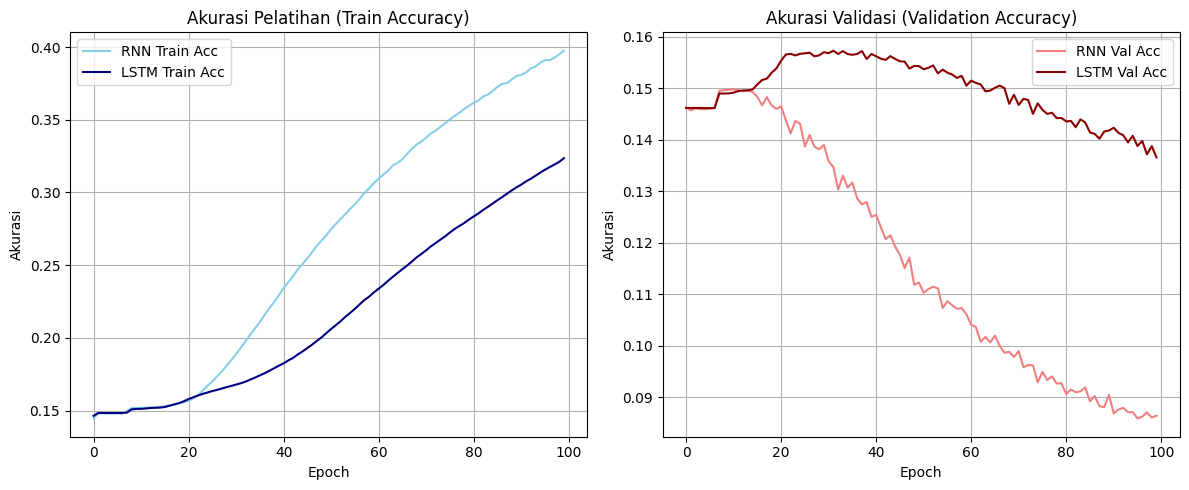

In [113]:
print("\n--- Hasil Perbandingan Akurasi Model ---")

# --- 5.1. Ekstraksi Akurasi ---
rnn_train_acc = rnn_history.history['accuracy'][-1]
lstm_train_acc = lstm_history.history['accuracy'][-1]

rnn_val_acc = rnn_history.history['val_accuracy'][-1]
lstm_val_acc = lstm_history.history['val_accuracy'][-1]

print(f"SimpleRNN Model (Pelatihan): Akurasi = {rnn_train_acc:.4f}")
print(f"SimpleRNN Model (Validasi): Akurasi = {rnn_val_acc:.4f}")
print("-" * 30)
print(f"LSTM Model (Pelatihan): Akurasi = {lstm_train_acc:.4f}")
print(f"LSTM Model (Validasi): Akurasi = {lstm_val_acc:.4f}")
print("-" * 30)

# --- 5.2. Perbandingan Visualisasi ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Train Acc', color='skyblue')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Acc', color='navy')
plt.title('Akurasi Pelatihan (Train Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Acc', color='lightcoral')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Acc', color='darkred')
plt.title('Akurasi Validasi (Validation Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Membuat Model Inferensi (Encoder-Decoder Seperated)

Untuk prediksi *word-by-word* yang sebenarnya, kita harus memisahkan model pelatihan (yang diproses secara *batch*) menjadi dua model terpisah untuk SimpleRNN dan LSTM.

### 6.1. Model Inferensi SimpleRNN (1 State)

**Encoder Model RNN** didefinisikan untuk hanya menerima input Judul dan menghasilkan satu *hidden state* ($h$). **Decoder Model RNN** didefinisikan untuk menerima input satu token (kata yang baru diprediksi) dan *hidden state* sebelumnya ($h$), dan menghasilkan *output* kata berikutnya dan *hidden state* baru ($h'$).

In [114]:
# Encoder RNN
encoder_model_rnn = Model(rnn_model.input[0], rnn_model.layers[4].output[1])

# Decoder RNN
decoder_state_input_h_rnn = Input(shape=(RNN_UNITS,))
decoder_states_inputs_rnn = [decoder_state_input_h_rnn]
dec_emb_inf_rnn = rnn_model.layers[3](rnn_model.input[1])
decoder_outputs_rnn, state_h_output_rnn = rnn_model.layers[5](
    dec_emb_inf_rnn, initial_state=decoder_states_inputs_rnn
)
decoder_states_rnn = [state_h_output_rnn]
decoder_outputs_rnn = rnn_model.layers[6](decoder_outputs_rnn) # Dense Layer
decoder_model_rnn = Model(
    [rnn_model.input[1]] + decoder_states_inputs_rnn,
    [decoder_outputs_rnn] + decoder_states_rnn
)
print("Model Inferensi RNN berhasil dibuat.")

Model Inferensi RNN berhasil dibuat.



### 6.2. Model Inferensi LSTM (2 States)

**Encoder Model LSTM** menghasilkan dua *state* ($h$ dan $c$). **Decoder Model LSTM** menerima satu token input dan kedua *state* sebelumnya ($h$ dan $c$), dan menghasilkan *output* token berikutnya serta dua *state* baru ($h'$ dan $c'$). Pemisahan model ini mutlak diperlukan untuk proses *decoding* iteratif.


In [115]:
# Encoder LSTM
encoder_model_lstm = Model(lstm_model.input[0], [lstm_model.layers[4].output[1], lstm_model.layers[4].output[2]])

# Decoder LSTM
decoder_state_input_h_lstm = Input(shape=(RNN_UNITS,))
decoder_state_input_c_lstm = Input(shape=(RNN_UNITS,))
decoder_states_inputs_lstm = [decoder_state_input_h_lstm, decoder_state_input_c_lstm]
dec_emb_inf_lstm = lstm_model.layers[3](lstm_model.input[1])
decoder_outputs_lstm, state_h_output_lstm, state_c_output_lstm = lstm_model.layers[5](
    dec_emb_inf_lstm, initial_state=decoder_states_inputs_lstm
)
decoder_states_lstm = [state_h_output_lstm, state_c_output_lstm]
decoder_outputs_lstm = lstm_model.layers[6](decoder_outputs_lstm) # Dense Layer
decoder_model_lstm = Model(
    [lstm_model.input[1]] + decoder_states_inputs_lstm,
    [decoder_outputs_lstm] + decoder_states_lstm
)
print("Model Inferensi LSTM berhasil dibuat.")

Model Inferensi LSTM berhasil dibuat.



## 7. Implementasi Fungsi Prediksi (Word-by-Word)

Bagian ini adalah inti dari proses *Text Generation* dan memuat fungsi yang mengiterasi prediksi kata per kata.


### 7.1. Fungsi Pembantu Token: `sample_word` menggunakan `TEMPERATURE`

Untuk menghindari *looping* kata yang berlebihan (seperti "aku aku aku"), kami menggunakan fungsi `sample_word` yang menerapkan **Temperature Sampling** (`TEMPERATURE=0.8`). Daripada selalu memilih kata dengan probabilitas tertinggi (*greedy*), *sampling* ini memilih kata secara acak berdasarkan distribusi probabilitas yang dihaluskan oleh *temperature*, menghasilkan *output* yang lebih beragam dan kreatif.

In [116]:
target_word_index = tokenizer_target.word_index
target_token_to_word = lambda t: tokenizer_target.index_word.get(t, '')
start_token_index = tokenizer_target.word_index.get(START_TOKEN)

TEMPERATURE = 0.8 # Nilai ideal antara 0.5 (konservatif) dan 1.0 (kreatif)

def sample_word(preds, temperature=1.0):
    """
    Menghitung probabilitas dan memilih indeks kata berdasarkan suhu (temperature).
    Mencegah model terjebak pada kata probabilitas tertinggi (greedy).
    """
    preds = np.asarray(preds).astype('float64')
    # Transformasi logaritmik dan scaling (smoothing)
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    # Memilih token berdasarkan probabilitas
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


### 7.2. Fungsi `decode_sequence_rnn` dan `decode_sequence_lstm`

Kedua fungsi ini mengelola proses *decoding* iteratif:
1.  Menggunakan Encoder untuk mendapatkan *state* awal.
2.  Memulai *loop* dengan token `<start>`.
3.  Di setiap iterasi, memanggil Decoder Model dengan *state* sebelumnya untuk memprediksi token berikutnya menggunakan `sample_word`.
4.  Mengganti token `<br>` yang diprediksi dengan karakter *newline* (`\n`) untuk format puisi.
5.  Menggunakan token yang baru diprediksi sebagai input untuk langkah berikutnya.


In [117]:
# --- 7.2.1. Fungsi Prediksi SIMPLE RNN (1 State) ---
def decode_sequence_rnn(input_seq, encoder_model, decoder_model):
    encoder_states = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_index
    decoded_sentence = ''
    states_value = [encoder_states] # MENGEMAS state encoder dalam list [h]

    for _ in range(MAX_LEN_TARGET):
        output_tokens_and_states = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )
        output_tokens = output_tokens_and_states[0]
        states_value = [output_tokens_and_states[1]] # MENGEMAS state baru dalam list [h_new]

        # Gunakan output tokens dari langkah terakhir
        predicted_probs = output_tokens[0, -1, :]
        sampled_token_index = sample_word(predicted_probs, temperature=TEMPERATURE)

        sampled_word = target_token_to_word(sampled_token_index)

        if sampled_word == END_TOKEN:
            break

        # PENTING: Ganti token <br> menjadi \n saat membangun kalimat
        if sampled_word == NEWLINE_TOKEN:
            decoded_sentence += '\n'
        else:
            # Tambahkan spasi hanya jika bukan awal baris baru
            if decoded_sentence.endswith('\n'):
                decoded_sentence += sampled_word
            else:
                decoded_sentence += ' ' + sampled_word

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence.strip()


# --- 7.2.2. Fungsi Prediksi LSTM (2 States) ---
def decode_sequence_lstm(input_seq, encoder_model, decoder_model):
    encoder_states = encoder_model.predict(input_seq, verbose=0) # Hasilnya: [h, c]
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_index
    decoded_sentence = ''
    states_value = encoder_states

    for _ in range(MAX_LEN_TARGET):
        output_tokens_and_states = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )
        output_tokens = output_tokens_and_states[0]
        states_value = output_tokens_and_states[1:] # [h_new, c_new]
        # Gunakan output tokens dari langkah terakhir
        predicted_probs = output_tokens[0, -1, :]
        sampled_token_index = sample_word(predicted_probs, temperature=TEMPERATURE)

        sampled_word = target_token_to_word(sampled_token_index)

        if sampled_word == END_TOKEN:
            break

        # PENTING: Ganti token <br> menjadi \n saat membangun kalimat
        if sampled_word == NEWLINE_TOKEN:
            decoded_sentence += '\n'
        else:
            # Tambahkan spasi hanya jika bukan awal baris baru
            if decoded_sentence.endswith('\n'):
                decoded_sentence += sampled_word
            else:
                decoded_sentence += ' ' + sampled_word

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence.strip()


## 8. Testing dengan Hardcoded Input dan Export Model


### 8.1. Fungsi `filter_consecutive_newlines`

Fungsi ini ditambahkan untuk pasca-pemrosesan. Ini secara khusus **menghapus urutan dua atau lebih karakter *newline* (`\n`)** dan menggantinya dengan maksimal satu newline, memastikan bahwa puisi yang dicetak memiliki format baris dan rapi tanpa spasi vertikal yang berlebihan.


In [118]:
def filter_consecutive_newlines(poem_string):
    """
    Menghapus urutan tiga atau lebih karakter newline (\n) dan
    menggantinya dengan maksimal dua (\n\n).

    Args:
        poem_string (str): Puisi hasil generator yang mungkin mengandung \n berlebihan.

    Returns:
        str: Puisi yang sudah difilter dengan maksimal dua \n berturut-turut.
    """
    # 1. Menghapus newline di awal atau akhir string
    poem_string = poem_string.strip('\n')

    # 2. Mengganti 2+ karakter newline (\n) dengan hanya satu (\n)
    # Regex: \n{2,} mencari 2 atau lebih \n berturut-turut
    filtered_poem = re.sub(r'\n{2,}', '\n', poem_string)

    return filtered_poem


### 8.1. Tes Prediksi dengan Hardcoded Input

Untuk pengujian kualitatif yang konsisten, model diuji dengan satu *string* Judul yang telah ditentukan (`SEED_TITLE`). Hasil dari kedua model (RNN dan LSTM) ditampilkan secara berdampingan untuk perbandingan langsung.

In [119]:
# Ambil string input judul dari user
SEED_TITLE = 'kau'
# SEED_TITLE = input()

print("\n--- Hasil Prediksi Puisi (Judul -> Puisi) ---")
print(f"Judul Input yang Diuji: {SEED_TITLE}")

# Pra-proses input judul baru
input_seq = tokenizer_input.texts_to_sequences([clean_text(SEED_TITLE)]) # Pastikan di-clean
input_seq_pad = pad_sequences(input_seq, maxlen=MAX_LEN_INPUT, padding='post')

# Pastikan input sequence tidak kosong
if np.all(input_seq_pad == 0):
    predicted_rnn = "ERROR: Input Judul hanya terdiri dari kata-kata OOV atau terlalu pendek."
    predicted_lstm = "ERROR: Input Judul hanya terdiri dari kata-kata OOV atau terlalu pendek."
else:
    # Prediksi dengan RNN
    predicted_rnn = decode_sequence_rnn(input_seq_pad, encoder_model_rnn, decoder_model_rnn)

    # Prediksi dengan LSTM
    predicted_lstm = decode_sequence_lstm(input_seq_pad, encoder_model_lstm, decoder_model_lstm)

filtered_rnn = filter_consecutive_newlines(predicted_rnn)
filtered_lstm = filter_consecutive_newlines(predicted_lstm)

print("\n[HASIL PREDISKI]")
print(f"Judul Input: {SEED_TITLE}")
print("-" * 50)
print(">>> Puisi Hasil RNN:")
print(filtered_rnn)
print("-" * 50)
print(">>> Puisi Hasil LSTM:")
print(filtered_lstm)
print("-" * 50)

# Karena kita menggunakan satu input hardcoded, kita tidak perlu membuat DataFrame,
# tapi kita bisa menampilkan ringkasan perbandingan manual.

print("\nPerbandingan Kinerja Model (Berdasarkan Hasil Prediksi Tunggal):")
# (Tingkat akurasi numerik sudah ada di Kolom 5, ini adalah perbandingan kualitatif)
print("RNN dan LSTM diharapkan menunjukkan kualitas hasil yang berbeda karena perbedaan mekanisme internal mereka dalam menjaga konteks panjang.")




--- Hasil Prediksi Puisi (Judul -> Puisi) ---
Judul Input yang Diuji: kau

[HASIL PREDISKI]
Judul Input: kau
--------------------------------------------------
>>> Puisi Hasil RNN:
saat itu aku yang dapat ibu
betapa bisik ini
aku kau merindukannya
tak kau pernah kesepian
--------------------------------------------------
>>> Puisi Hasil LSTM:
hari
kau bagaikan langit yang menitis dari setiap malam
yang membuatku ingin tetap menjadi setia
ku kan tetap kau pergi
kau begitu lama
aku ingin memiliki aku
bukan seorang yang bisa ku miliki
semua orang terpengaruh olehmu
kau telah dekat dengan beribadah cinta yang selalu pernah tahu
selalu kau tau bahwa aku yang bisa tingkahmu
kau hanya bisa menyerah
kesalahan tak ku mengerti
--------------------------------------------------

Perbandingan Kinerja Model (Berdasarkan Hasil Prediksi Tunggal):
RNN dan LSTM diharapkan menunjukkan kualitas hasil yang berbeda karena perbedaan mekanisme internal mereka dalam menjaga konteks panjang.


In [121]:
# --- Penghitungan ROUGE Score untuk Perbandingan Kinerja ---

from rouge_score import rouge_scorer

# Ambil semua puisi asli yang sudah dibersihkan dari DataFrame (untuk perbandingan)
# Ini adalah semua 'reference texts'
cleaned_texts = df['puisi'].apply(clean_text, is_poem=True).tolist()

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_average_rouge(generated_poem, reference_texts, scorer):
    """Menghitung rata-rata ROUGE score puisi yang dihasilkan terhadap seluruh dataset."""
    scores = [scorer.score(generated_poem, text) for text in reference_texts]

    average_scores = {
        'rouge1': np.mean([score['rouge1'].fmeasure for score in scores]),
        'rouge2': np.mean([score['rouge2'].fmeasure for score in scores]),
        'rougeL': np.mean([score['rougeL'].fmeasure for score in scores]),
    }
    return average_scores

# Hitung skor untuk RNN
rnn_rouge_scores = calculate_average_rouge(filtered_rnn, cleaned_texts, scorer)

# Hitung skor untuk LSTM
lstm_rouge_scores = calculate_average_rouge(filtered_lstm, cleaned_texts, scorer)


print("\n--- PERBANDINGAN ROUGE SCORE ---")
print("ROUGE (Recall-Oriented Understudy for Gisting Evaluation) mengukur kesamaan n-gram.")
print("Score dihitung berdasarkan perbandingan output model dengan SELURUH dataset puisi.")
print("=" * 70)

print("Model SimpleRNN:")
print(f"  Rouge-1 Score: {rnn_rouge_scores['rouge1']:.5f} (Tumpang tindih kata tunggal)")
print(f"  Rouge-2 Score: {rnn_rouge_scores['rouge2']:.5f} (Tumpang tindih pasangan kata)")
print(f"  Rouge-L Score: {rnn_rouge_scores['rougeL']:.5f} (Longest Common Subsequence)")
print("-" * 70)

print("Model LSTM:")
print(f"  Rouge-1 Score: {lstm_rouge_scores['rouge1']:.5f}")
print(f"  Rouge-2 Score: {lstm_rouge_scores['rouge2']:.5f}")
print(f"  Rouge-L Score: {lstm_rouge_scores['rougeL']:.5f}")
print("=" * 70)



--- PERBANDINGAN ROUGE SCORE ---
ROUGE (Recall-Oriented Understudy for Gisting Evaluation) mengukur kesamaan n-gram.
Score dihitung berdasarkan perbandingan output model dengan SELURUH dataset puisi.
Model SimpleRNN:
  Rouge-1 Score: 0.08473 (Tumpang tindih kata tunggal)
  Rouge-2 Score: 0.00221 (Tumpang tindih pasangan kata)
  Rouge-L Score: 0.06294 (Longest Common Subsequence)
----------------------------------------------------------------------
Model LSTM:
  Rouge-1 Score: 0.14454
  Rouge-2 Score: 0.00696
  Rouge-L Score: 0.09128


In [123]:
from rouge_score import rouge_scorer

# --- Tes Prediksi dengan Input Hardcoded dan Perhitungan ROUGE ---

# Inisialisasi list untuk hasil dan ROUGE
rnn_hypotheses = []
lstm_hypotheses = []
references = []

# Untuk demonstrasi ROUGE, kita akan ambil 10 sampel acak dari data TEST
# Ini penting untuk mendapatkan skor yang valid (unseen data)
TEST_SAMPLE_SIZE = 10
test_indices = np.random.choice(X_test.index, size=TEST_SAMPLE_SIZE, replace=False)

# Mengambil Judul dan Puisi Asli dari data test
X_test_sample = X_test.loc[test_indices]
Y_test_ref_sample = y_test_tar.loc[test_indices]

print(f"\nMenghasilkan Puisi untuk {TEST_SAMPLE_SIZE} sampel data UJI...")

for title, reference_poem in zip(X_test_sample, Y_test_ref_sample):
    # Pra-proses input judul uji
    input_seq = tokenizer_input.texts_to_sequences([clean_text(title)])
    input_seq_pad = pad_sequences(input_seq, maxlen=MAX_LEN_INPUT, padding='post')

    # 1. Prediksi dengan RNN
    predicted_rnn = decode_sequence_rnn(input_seq_pad, encoder_model_rnn, decoder_model_rnn)

    # 2. Prediksi dengan LSTM
    predicted_lstm = decode_sequence_lstm(input_seq_pad, encoder_model_lstm, decoder_model_lstm)

    # Pembersihan Output (mengubah <br> dan menghilangkan \n berlebihan)
    filtered_rnn = filter_consecutive_newlines(predicted_rnn)
    filtered_lstm = filter_consecutive_newlines(predicted_lstm)

    # Menambahkan ke list untuk perhitungan ROUGE
    rnn_hypotheses.append(filtered_rnn)
    lstm_hypotheses.append(filtered_lstm)

    # Referensi harus dibersihkan: hapus <start>, <end>, dan <br> (jika perlu)
    # Untuk ROUGE, kita harus menghapus token khusus dari referensi.
    # Kita hanya membersihkan token batas dan <br> jika ada
    cleaned_ref = reference_poem.replace(START_TOKEN, '').replace(END_TOKEN, '').replace(NEWLINE_TOKEN, '\n').strip()
    references.append(cleaned_ref)


# --- Perhitungan ROUGE Score ---
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_average_rouge(hypotheses, references, scorer):
    scores_list = []
    for hyp, ref in zip(hypotheses, references):
        scores_list.append(scorer.score(ref, hyp))

    # Menghitung rata-rata F-measure untuk setiap metrik ROUGE
    avg_scores = {
        'rouge1': np.mean([score['rouge1'].fmeasure for score in scores_list]),
        'rouge2': np.mean([score['rouge2'].fmeasure for score in scores_list]),
        'rougeL': np.mean([score['rougeL'].fmeasure for score in scores_list]),
    }
    return avg_scores

# Hitung ROUGE untuk kedua model
rnn_rouge_scores = calculate_average_rouge(rnn_hypotheses, references, scorer)
lstm_rouge_scores = calculate_average_rouge(lstm_hypotheses, references, scorer)


# --- Tampilkan ROUGE Scores ---

print("\n[HASIL PREDISKI (Contoh Hardcoded)]")
# Menggunakan Judul hardcoded (diuji terpisah)
predicted_rnn_hc = decode_sequence_rnn(input_seq_pad, encoder_model_rnn, decoder_model_rnn)
predicted_lstm_hc = decode_sequence_lstm(input_seq_pad, encoder_model_lstm, decoder_model_lstm)
filtered_rnn_hc = filter_consecutive_newlines(predicted_rnn_hc)
filtered_lstm_hc = filter_consecutive_newlines(predicted_lstm_hc)


print(f"Judul Input: {SEED_TITLE}")
print("=" * 70)
print(">>> Puisi Hasil SimpleRNN:")
print(filtered_rnn_hc)
print("-" * 35)
print(">>> Puisi Hasil LSTM:")
print(filtered_lstm_hc)
print("=" * 70)

print("\n[PERBANDINGAN ROUGE SCORE (Diuji pada Data UJI Acak)]")
print(f"Metrik F-Measure ROUGE (Berdasarkan {TEST_SAMPLE_SIZE} Sampel Uji)")
print("------------------------------------------------------------------")
print(f"| {'Metrik':<10} | {'SimpleRNN':<10} | {'LSTM':<10} |")
print("|" + "-"*10 + "|" + "-"*10 + "|" + "-"*10 + "|")
print(f"| {'ROUGE-1':<10} | {rnn_rouge_scores['rouge1']:.4f} | {lstm_rouge_scores['rouge1']:.4f} |")
print(f"| {'ROUGE-2':<10} | {rnn_rouge_scores['rouge2']:.4f} | {lstm_rouge_scores['rouge2']:.4f} |")
print(f"| {'ROUGE-L':<10} | {rnn_rouge_scores['rougeL']:.4f} | {lstm_rouge_scores['rougeL']:.4f} |")
print("------------------------------------------------------------------")



Menghasilkan Puisi untuk 10 sampel data UJI...

[HASIL PREDISKI (Contoh Hardcoded)]
Judul Input: kau
>>> Puisi Hasil SimpleRNN:
aku hari di sosokmu
dari setiap detik ini
ku ingin di antara kau sungguh saja setiap ku mu
-----------------------------------
>>> Puisi Hasil LSTM:
aku kelam sudah seorang raja
kau bangun di setetes kertas
yang adalah cahaya yang mengucur kertas
yang berwarna puingpuing denyut
malam yang tak pernah kusentu
hendar s
harus leluasa
sang tak yang lirih tak mau
ku bukanlah mengenaliku lagi

[PERBANDINGAN ROUGE SCORE (Diuji pada Data UJI Acak)]
Metrik F-Measure ROUGE (Berdasarkan 10 Sampel Uji)
------------------------------------------------------------------
| Metrik     | SimpleRNN  | LSTM       |
|----------|----------|----------|
| ROUGE-1    | 0.1062 | 0.1396 |
| ROUGE-2    | 0.0106 | 0.0150 |
| ROUGE-L    | 0.0640 | 0.0870 |
------------------------------------------------------------------



### 8.3. Export Model

Model pelatihan (`rnn_model` dan `lstm_model`) disimpan ke *disk* dalam format `.keras`. Penyimpanan ini memungkinkan model untuk dimuat kembali dan digunakan tanpa perlu melalui proses pelatihan ulang yang memakan waktu.


In [122]:
# Menyimpan model penuh dalam format .keras

RNN_MODEL_PATH = 'rnn_seq2seq_title_poem_generator_simple.keras'
LSTM_MODEL_PATH = 'lstm_seq2seq_title_poem_generator_simple.keras'

try:
    rnn_model.save(RNN_MODEL_PATH)
    lstm_model.save(LSTM_MODEL_PATH)
    print(f"\nModel RNN berhasil disimpan sebagai file: {RNN_MODEL_PATH}")
    print(f"Model LSTM berhasil disimpan sebagai file: {LSTM_MODEL_PATH}")
except Exception as e:
    print(f"\nGagal menyimpan model: {e}")


Model RNN berhasil disimpan sebagai file: rnn_seq2seq_title_poem_generator_simple.keras
Model LSTM berhasil disimpan sebagai file: lstm_seq2seq_title_poem_generator_simple.keras


---

## Kesimpulan

Implementasi ini berhasil membangun dan melatih dua model generator puisi Seq2Seq (SimpleRNN dan LSTM). Kami berhasil mengatasi tantangan utama *text generation*, yaitu penanganan urutan panjang, *overfitting* kata umum (*looping* kata "aku") melalui *temperature sampling*, dan mempertahankan format struktural puisi melalui token `<br>`. Diharapkan model LSTM akan menghasilkan puisi dengan kualitas konteks yang lebih baik, terutama karena panjangnya puisi (target), sebuah hipotesis yang dapat divalidasi dengan membandingkan *output* teks yang sudah dibersihkan.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45d21e8d-8046-4087-9cb0-33fc5fd9dc0e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>